In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp

import xgboost as xgb

from scipy import sparse
from IPython.display import Image
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

sns.set(style="ticks", color_codes=True)
%matplotlib inline

import os
import json

from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from datetime import datetime
import dateutil

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder


In [4]:
Path = "profiles/"
filelist = os.listdir(Path)

In [3]:
def read_all():
    
    flag=0
    flag2=0
    
    user_keys = ['alias', 'username', 'numberPosts', 'descriptionProfile', 'numberFollowers', 'numberFollowing', 'urlProfile', 'urlImgProfile', 'website'] # The keys you want
    post_keys = ['url', 'urlImage', 'numberLikes', 'localization', 'date', 'description', 'tags', 'multipleImage', 'mentions', 'isVideo', 'filename'] # The keys you want
    
    #user_cols=['urlProfile', 'numberPosts', 'alias', 'descriptionProfile',  'numberFollowers', 'urlImgProfile', 'username', 'website', 'numberFollowing']
    user_cols=['urlProfile', 'alias', 'numberFollowing', 'numberFollowers', 'username', 'numberPosts', 'website', 'descriptionProfile',  'urlImgProfile']
    # might switch multipleImage and isVideo
    post_cols = ['url', 'description',  'date', 'numberLikes', 'tags', 'filename', 'urlImage', 'localization', 'isVideo', 'multipleImage', 'mentions']
    
    for k in filelist:
        if k.endswith(".json"):  # You could also add "and i.startswith('f')
            
            # Read file
            with open(Path + str(k)) as json_data:
                        data = json.load(json_data)
                            
            if (data['posts']!=[]):
                
                if data["descriptionProfile"]!=None:
                    temp=data["descriptionProfile"]
                    data["descriptionProfile"]=temp[0]
                           
                # Generate user data
                user_data=dict((k, data[k]) for k in user_keys if k in data)
                user_df=pd.DataFrame.from_dict(user_data, orient='index').T

                # Generate posts data for given user
                for i in range(0,len(data['posts'])):
                    
                    for k in post_keys:
                        if k in data['posts'][i]:
                            if isinstance(data['posts'][i][k], str):
                                data['posts'][i][k]=data['posts'][i][k].replace('\r','')

                    post=dict((k, data['posts'][i][k]) for k in post_keys if k in data['posts'][i])

                    if (flag==0):
                        all_posts=np.hstack((user_df, pd.DataFrame.from_dict(post, orient='index').T))
                        flag=1
                    else:
                        new_post=np.hstack((user_df, pd.DataFrame.from_dict(post, orient='index').T))
                        all_posts=np.vstack((all_posts,new_post)) 


                if (flag2==0):
                    total=pd.DataFrame(all_posts, columns=list(reversed(user_keys))+list(reversed(post_keys)))
                    flag2=1
                else:
                    total=np.vstack((total,pd.DataFrame(all_posts, columns=list(reversed(user_keys))+list(reversed(post_keys)))))   
           
                flag=0

    dataset=pd.DataFrame(total, columns=user_cols+post_cols)
    return dataset[["alias", "username", "numberFollowers", "numberFollowing", "numberPosts", 'urlProfile', 'urlImgProfile', 'descriptionProfile', 'website', 'filename', 'url', 'urlImage', 'numberLikes', 'description', 'tags', 'mentions', 'localization', 'date', 'multipleImage', 'isVideo']]

In [ ]:
dataset = read_all()
dataset.to_csv('newDataset.csv', index=False)

# Import Dataset

In [198]:
full=pd.read_csv('dataset.csv', sep=',', na_values='NaN')
y=full["numberLikes"]

toDrop = ['username', 'urlProfile', 'urlImgProfile', 'filename', 'url', 'urlImage', 'isVideo']
processed = full.drop(toDrop,axis=1)

nonCat = ['descriptionProfile', 'description', 'tags', 'mentions', 'localization']
processed = processed.drop(nonCat, axis=1)

# NLP

In [199]:
nlp = pd.read_csv('NLP_feature.csv', sep=',', na_values='NaN')
nlp = nlp.drop(["Unnamed: 0"],axis=1)

# Select data

In [200]:
pd.options.display.float_format = '{:.2f}'.format
processed.describe()

,numberPosts,numberFollowing,numberFollowers,numberLikes
count,16539.00,16539.00,16539.00,16539.00
mean,2315.73,2590.56,997829.41,24414.26
std,2655.38,59090.66,1934400.77,64220.60
min,15.00,0.00,124965.00,0.00
25%,787.00,191.00,198039.00,3232.50
50%,1481.00,396.00,393843.00,7351.00
75%,2932.00,645.00,935310.00,18357.00
max,27671.00,1838511.00,22130730.00,1115123.00


(array([  1.54160000e+04,   6.13000000e+02,   2.34000000e+02,
          9.10000000e+01,   6.60000000e+01,   4.00000000e+01,
          2.30000000e+01,   1.50000000e+01,   5.00000000e+00,
          1.10000000e+01,   8.00000000e+00,   5.00000000e+00,
          5.00000000e+00,   4.00000000e+00,   3.00000000e+00]),
 array([       0.        ,    74341.53333333,   148683.06666667,
          223024.6       ,   297366.13333333,   371707.66666667,
          446049.2       ,   520390.73333333,   594732.26666667,
          669073.8       ,   743415.33333333,   817756.86666667,
          892098.4       ,   966439.93333333,  1040781.46666667,  1115123.        ]),
 <a list of 15 Patch objects>)

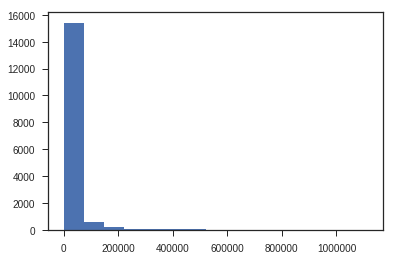

In [201]:
plt.hist(processed.numberLikes, 15)
#plt.xlim(80000, 800000)
#plt.ylim(0, 2000)

(array([ 14244.,   1190.,    374.,    255.,    153.,     68.,    119.,
            34.,     17.,     17.,     17.,     17.,      0.,     17.,
            17.]),
 array([   124965.,   1592016.,   3059067.,   4526118.,   5993169.,
          7460220.,   8927271.,  10394322.,  11861373.,  13328424.,
         14795475.,  16262526.,  17729577.,  19196628.,  20663679.,
         22130730.]),
 <a list of 15 Patch objects>)

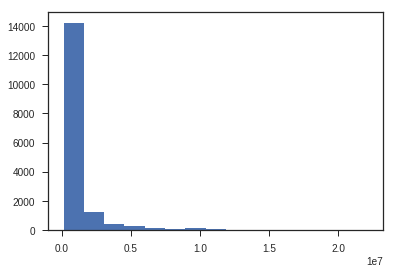

In [202]:
plt.hist(processed.numberFollowers, 15)

In [203]:
le = preprocessing.LabelEncoder()
le.fit(processed["alias"])
list(le.classes_)
alias_num=le.transform(processed["alias"])
#list(le.inverse_transform(alias_num))
processed["aliasNum"]=alias_num

In [204]:
avgLikes = []
numFollowers = []
selection = []

for i in range(0,np.max(processed["aliasNum"],axis=0)):
    numFollowers=np.append(numFollowers, processed[processed["aliasNum"]==i]['numberFollowers'].iloc[0])
    avgLikes=np.append(avgLikes, np.sum(processed[processed["aliasNum"]==i]["numberLikes"])/len(processed[processed["aliasNum"]==i]))
    processed.loc[processed["aliasNum"]==i, 'ratio']=avgLikes[i]
    if (avgLikes[i]<200000 and processed[processed["aliasNum"]==i]['numberFollowers'].iloc[0]<1000000):
        selection=np.append(selection, i)

In [205]:
pd.DataFrame(selection).describe()

,0
count,746.00
mean,479.87
std,281.85
min,0.00
25%,239.25
50%,477.50
75%,725.50
max,971.00


In [206]:
po=pd.DataFrame(avgLikes/numFollowers)
po.describe()

,0
count,972.00
mean,0.02
std,0.02
min,0.00
25%,0.01
50%,0.02
75%,0.03
max,0.17


In [207]:
processed = pd.concat([processed, nlp], axis=1)

In [208]:
filtered=processed[processed['aliasNum'].isin(selection)]
filtered.describe()

,numberPosts,numberFollowing,numberFollowers,numberLikes,aliasNum,ratio,able,account,actually,ad,...,yang,year,years,yes,yesterday,yet,yo,yoga,young,youtube
count,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,...,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00
mean,1941.02,3026.48,362515.26,8306.70,479.80,8306.70,0.01,0.01,0.01,0.02,...,0.01,0.02,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01
std,2007.64,67258.90,227120.79,9998.49,281.63,9335.25,0.08,0.09,0.08,0.12,...,0.24,0.18,0.18,0.10,0.10,0.11,0.12,0.16,0.10,0.10
min,15.00,0.00,124965.00,0.00,0.00,110.87,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,722.00,202.00,180286.00,2630.00,239.00,2882.18,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1369.00,405.00,283490.00,5297.00,477.00,5448.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2566.00,656.00,493550.00,10323.25,726.00,10379.94,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,19590.00,1838511.00,996578.00,180164.00,971.00,120681.47,2.00,2.00,2.00,3.00,...,9.00,4.00,4.00,3.00,2.00,4.00,8.00,7.00,4.00,3.00


(0, 200000)

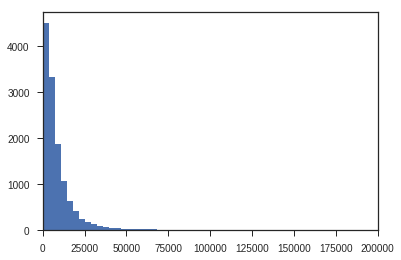

In [209]:
plt.hist(filtered.numberLikes, 50)
plt.xlim(0, 200000)
#plt.ylim(0, 2000)

(0, 1000000)

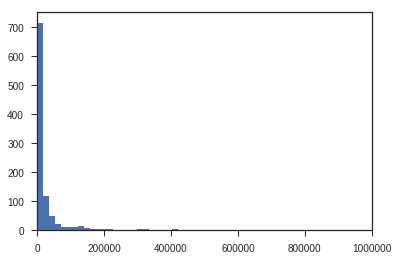

In [210]:
plt.hist(avgLikes,50)
plt.xlim(0, 1000000)
#plt.ylim(0, 2000)

In [211]:
pd.DataFrame(avgLikes).describe()

,0
count,972.00
mean,24429.64
std,61732.63
min,110.87
25%,3594.37
50%,7689.24
75%,18719.16
max,875806.41


# Feature extraction

In [212]:
modified = filtered.drop(["alias"],axis=1)
modified = modified.reset_index(drop=True)

### Convert website to categorical features

In [213]:
modified['you']=modified['website'].str.contains("youtube|youtu", na=False).astype(int)
modified['music']=modified['website'].str.contains("soundcloud|spoti", na=False).astype(int)
modified['tumblr']=modified['website'].str.contains("tumblr", na=False).astype(int)
modified['facebook']=modified['website'].str.contains("facebook", na=False).astype(int)
modified['blog']=modified['website'].str.contains("blog|wordpress", na=False).astype(int)
modified['twitter']=modified['website'].str.contains("twitter", na=False).astype(int)
modified['other']=modified['website'].str.contains(".", na=False).astype(int)

modified = modified.drop(['website'], axis=1)

### Convert multipleImage to int

In [214]:
modified['multipleImage']=modified['multipleImage'].astype(int)

### Convert dates to days of week

In [215]:
copy=modified["date"].copy()
for i in range(0, len(modified)):
    copy[i] = datetime.weekday((dateutil.parser.parse(modified["date"][i])))
modified["date"]=copy.astype(np.int64)

modified['mon']=(modified['date']==0).astype(int)
modified['tue']=(modified['date']==1).astype(int)
modified['wed']=(modified['date']==2).astype(int)
modified['thu']=(modified['date']==3).astype(int)
modified['fri']=(modified['date']==4).astype(int)
modified['sat']=(modified['date']==5).astype(int)
modified['sun']=(modified['date']==6).astype(int)

modified = modified.drop(['date'], axis=1)

### One hot encode alias number

In [123]:
# One hot encoding
encoder = OneHotEncoder()
encoder.fit(modified["aliasNum"].values.reshape(-1, 1))
alias_sparse = encoder.transform(modified["aliasNum"].values.reshape(-1, 1))

In [23]:
y = modified['numberLikes']
modified = modified.drop(['numberLikes'],axis=1)

In [146]:
modified=sp.sparse.hstack((modified.astype(float), alias_sparse))

In [119]:
modified.describe()

,numberPosts,numberFollowing,numberFollowers,multipleImage,numberLikes,aliasNum,ratio,you,music,tumblr,...,blog,twitter,other,mon,tue,wed,thu,fri,sat,sun
count,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,...,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00
mean,1941.02,3026.48,362515.26,0.03,8306.70,479.80,8306.70,0.11,0.01,0.00,...,0.02,0.00,0.88,0.11,0.13,0.14,0.15,0.14,0.15,0.18
std,2007.64,67258.90,227120.79,0.17,9998.49,281.63,9335.25,0.32,0.07,0.04,...,0.14,0.05,0.32,0.32,0.34,0.35,0.36,0.35,0.35,0.38
min,15.00,0.00,124965.00,0.00,0.00,0.00,110.87,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,722.00,202.00,180286.00,0.00,2630.00,239.00,2882.18,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1369.00,405.00,283490.00,0.00,5297.00,477.00,5448.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2566.00,656.00,493550.00,0.00,10323.25,726.00,10379.94,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,19590.00,1838511.00,996578.00,1.00,180164.00,971.00,120681.47,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


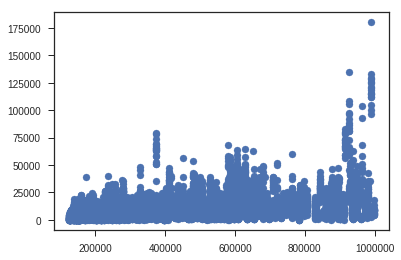

In [216]:
plt.scatter(modified["numberFollowers"], modified["numberLikes"])

# Create train and test dataset

In [217]:
deleted=modified[modified["aliasNum"]==0][0:2]
test=modified[modified["aliasNum"]==0][3:6]
train=modified[modified["aliasNum"]==0][6:len(modified[modified["aliasNum"]==0])]

for i in range(1,np.max(modified["aliasNum"],axis=0)):
#for i in range(0,10):
    deleted = pd.concat([deleted, modified[modified["aliasNum"]==i][0:2]], axis=0)
    test = pd.concat([test, modified[modified["aliasNum"]==i][3:6]], axis=0)
    train = pd.concat([train, modified[modified["aliasNum"]==i][6:len(modified[modified["aliasNum"]==i])]], axis=0)

In [218]:
X_train = train.drop(['numberLikes'],axis=1)
y_train = train['numberLikes']
X_test = test.drop(['numberLikes'],axis=1)
y_test = test['numberLikes']

In [23]:
y = modified['numberLikes']
modified = modified.drop(['numberLikes'],axis=1)

In [24]:
modified.describe()

,numberPosts,numberFollowing,numberFollowers,multipleImage,aliasNum,ratio,able,account,actually,ad,...,tumblr,facebook,twitter,other,mon,tue,wed,thu,fri,sat
count,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,...,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00
mean,1941.02,3026.48,362515.26,0.03,479.80,8306.70,0.01,0.01,0.01,0.02,...,0.00,0.04,0.00,0.88,0.11,0.13,0.14,0.15,0.14,0.15
std,2007.64,67258.90,227120.79,0.17,281.63,9335.25,0.08,0.09,0.08,0.12,...,0.04,0.21,0.05,0.32,0.32,0.34,0.35,0.36,0.35,0.35
min,15.00,0.00,124965.00,0.00,0.00,110.87,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,722.00,202.00,180286.00,0.00,239.00,2882.18,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1369.00,405.00,283490.00,0.00,477.00,5448.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2566.00,656.00,493550.00,0.00,726.00,10379.94,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
max,19590.00,1838511.00,996578.00,1.00,971.00,120681.47,2.00,2.00,2.00,3.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


# Split train and test dataset

In [161]:
X_train, X_test, y_train, y_test = train_test_split(modified, y, test_size=0.2, random_state=0)

# XGB

In [189]:
model_xgb = xgb.XGBRegressor(max_depth=4, learning_rate=0.01, n_estimators=596)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
RMSE = mean_squared_error(y_test, y_pred)**0.5
print(RMSE)

3262.93110929


In [190]:
model_xgb.score(X_test,y_test)

0.82259649646716704

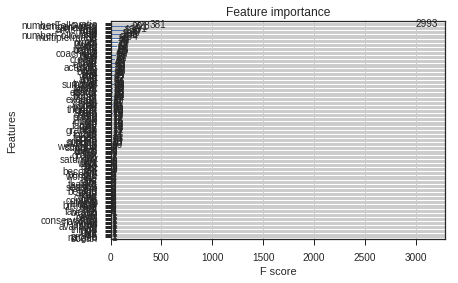

In [191]:
xgb.plot_importance(model_xgb, importance_type='weight') # weight, gain or cover

In [152]:
vec = model_xgb.feature_importances_

In [153]:
vec

array([  4.66951244e-02,   1.44871296e-02,   2.25067902e-02,
         2.06959005e-02,   2.04372015e-02,   4.04346138e-01,
         0.00000000e+00,   3.36308358e-03,   1.03479496e-03,
         7.11421529e-03,   7.89031200e-03,   0.00000000e+00,
         6.85551669e-03,   0.00000000e+00,   1.29349370e-04,
         3.88048124e-04,   0.00000000e+00,   2.58698739e-04,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         3.88048124e-04,   1.81089118e-02,   1.37110334e-02,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.29349370e-04,   0.00000000e+00,
         7.76096247e-04,   0.00000000e+00,   3.88048124e-04,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.22881904e-02,   0.00000000e+00,   1.29349370e-04,
         9.05445602e-04,   0.00000000e+00,   4.78592701e-03,
         5.17397479e-04,   1.68154179e-03,   0.00000000e+00,
         0.00000000e+00,   2.71633686e-03,   0.00000000e+00,
         2.58698757e-03,

In [192]:
for i in range(len(vec)):
    if vec[i] > 0.01:
        print(i)

0
1
2
3
4
5
22
23
36
77
179
248
257
265
269
423
432
514


### True vs pred

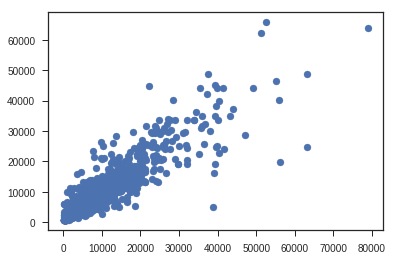

In [196]:
plt.scatter(y_test, y_pred)
#plt.xlim(0, 40000)
#plt.ylim(0, 60000)

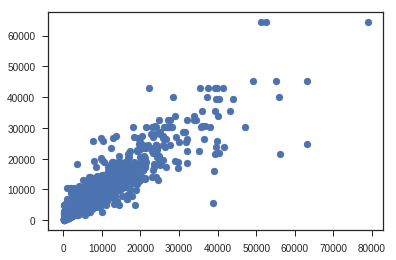

In [197]:
plt.scatter(y_test, X_test['ratio'])
#plt.xlim(0, 40000)
#plt.ylim(0, 60000)

In [158]:
RMSE = mean_squared_error(y_test, X_test['ratio'])**0.5
print(RMSE)

3507.03488338


### Test vs residuals

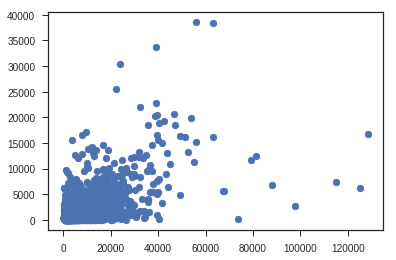

In [127]:
plt.scatter(y_test, abs(y_pred-y_test))

In [149]:
true = pd.DataFrame(y_test)
pred = pd.DataFrame(y_pred)

In [150]:
true = true.reset_index(drop=True)

In [151]:
true[(true<10000).values].index

Int64Index([   1,    5,    6,    7,    8,   11,   12,   13,   17,   20,
            ...
            3215, 3216, 3217, 3219, 3220, 3222, 3224, 3225, 3227, 3229],
           dtype='int64', length=1978)

In [152]:
subTrue = true[(true<10000).values]

In [153]:
subPred = pred.ix[true[(true<10000).values].index]

(0, 10000)

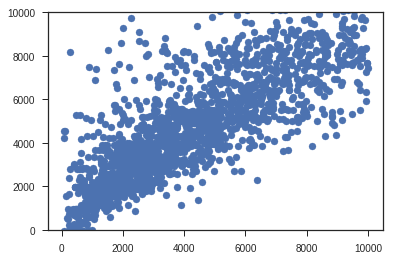

In [155]:
plt.scatter(subTrue,subPred)
plt.ylim(0, 10000)

In [162]:
def score(params):
    global best2
    global count
    count=count+1
    print(count)
    num_round = int(params['n_estimators'])
    del(params['n_estimators'])
    #params['n_estimators']=num_round
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, dtrain, num_round)
    predictions = model.predict(dvalid)
    score = mean_squared_error(y_test, predictions)**0.5
    
    if (score<best2):
        best2=score
        print(params)
        print(num_round)
        print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

In [165]:
def optimize():
    space = {
             'n_estimators' : hp.quniform('n_estimators', 100, 1000, 1),
             'learning_rate' : hp.quniform('learning_rate', 0.01, 0.2, 0.01),
             'max_depth' : hp.choice('max_depth', np.arange(3, 4, dtype=int)),
             #'min_child_weight' : hp.quniform('min_child_weight', 1, 4, 1),
            #'subsample' : hp.quniform('subsample', 0.6, 0.9, 0.05),
            # 'gamma' : hp.quniform('gamma', 0.6, 0.8, 0.05),
            #'colsample_bytree' : hp.quniform('colsample_bytree', 0.7, 1, 0.05),
              #'reg_alpha' : hp.quniform('reg_alpha', 0.001, 10, 0.01),
             #'reg_lambda' : hp.quniform('reg_lambda', 0.001, 10, 0.01),
             }

    best = fmin(score, space, algo=tpe.suggest, max_evals=50)

    print(best)

In [166]:
best2=100000
count=0
optimize()

1
{'max_depth': 3, 'learning_rate': 0.15}
257
	Score 3667.8827755100597


2
3
4
{'max_depth': 3, 'learning_rate': 0.01}
518
	Score 3631.2273271904


5
6
7
8
9
{'max_depth': 3, 'learning_rate': 0.13}
108
	Score 3623.3584956195396


10
11
12
13
14
15
16
17
18
19
{'max_depth': 3, 'learning_rate': 0.1}
138
	Score 3620.447529798547


20
21
{'max_depth': 3, 'learning_rate': 0.09}
123
	Score 3615.5997506414537


22
{'max_depth': 3, 'learning_rate': 0.09}
159
	Score 3610.8324738235074


23
24
25
26
27
28
29
30
31
32
33
34


KeyboardInterrupt: 

# Presentation

### 1. Only the number of followers/posts

### 2. Add the avgLikes of a user

In [ ]:
#### 3. 